In [ ]:
# Based on the R code proposed by Morales & Villacreses (2022)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import normaltest, anderson
from sklearn.preprocessing import QuantileTransformer

from sklearn.metrics import r2_score, mean_squared_error

from joblib import Parallel, delayed
import multiprocessing

import statsmodels.formula.api as smf
import patsy

# Global Variables
LOAD_RAW = False

# Predefined functions

In [3]:
def print_normal_plots(data):
    # Q-Q Plot
    plt.figure()
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Q–Q Plot")
    plt.tight_layout()
    plt.show()

    # Histogram
    ## Fit a normal distribution to the data
    mu, std = stats.norm.fit(data)
    x = np.linspace(min(data), max(data), 1000)
    normal_pdf = stats.norm.pdf(x, mu, std)
    ## KDE using Gaussian kernel
    kde = stats.gaussian_kde(data)
    kde_pdf = kde(x)
    ## Plot
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=30, density=True, color='lightgray', edgecolor='black', alpha=0.7, label='Histogram')
    plt.plot(x, kde_pdf, label='KDE (Data)', linewidth=2)
    plt.plot(x, normal_pdf, 'r--', label=f'Normal PDF\n($\mu$={mu:.2f}, $\sigma$={std:.2f})', linewidth=2)
    plt.title("Histogram with KDE vs. Normal Distribution", fontsize=14)
    plt.xlabel("log_ingrl", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def normal_tests(data):
    print("-"*40)
    print("Normality tests:")
    print()
    # --- Anderson–Darling Test ---
    ad_result = stats.anderson(data, dist='norm')
    print("Anderson–Darling statistic:", ad_result.statistic)
    print("Critical values:", ad_result.critical_values)
    print("Significance levels:", ad_result.significance_level)
    for sl, cv in zip(ad_result.significance_level, ad_result.critical_values):
        if ad_result.statistic < cv:
            print(f"At {sl}% level: Fail to reject normality")
        else:
            print(f"At {sl}% level: Reject normality")

    # --- D’Agostino–Pearson Test ---
    dp_stat, dp_pvalue = stats.normaltest(data)
    print("\nD’Agostino–Pearson p-value:", dp_pvalue)

    if dp_pvalue < 0.1:
        print("Reject normality (p < 0.1)")
    else:
        print("Fail to reject normality (p ≥ 0.1)")
    print("-"*40)

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Diego\AppData\Local\Temp\ipykernel_9816\2856560196.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, normal_pdf, 'r--', label=f'Normal PDF\n($\mu$={mu:.2f}, $\sigma$={std:.2f})', linewidth=2)
C:\Users\Diego\AppData\Local\Temp\ipykernel_9816\2856560196.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, normal_pdf, 'r--', label=f'Normal PDF\n($\mu$={mu:.2f}, $\sigma$={std:.2f})', linewidth=2)


# Data Loading

In [ ]:
if LOAD_RAW:
    df = pd.read_stata("./data/raw/enemdu_2022_harmonized.dta")
    df.to_pickle("./data/raw/enemdu_2022_harmonized.pkl")

    df_c = pd.read_stata("./data/raw/cpv_2022_harmonized.dta")
    df_c.to_pickle("./data/raw/cpv_2022_harmonized.pkl")

if not LOAD_RAW:
    df = pd.read_pickle("./data/raw/enemdu_2022_harmonized.pkl")
    df_c = pd.read_pickle("./data/raw/cpv_2022_harmonized.pkl")

In [3]:
df_c.head()

,parroquia,sexo,edad,etnia,asistencia,curso_alto,sabe_leer,titulo,grupo,rama,aporte,area,categoria_ocupacion,nivel_instruccion,estado_conyugal
0,10150,1.0,29.0,Mestiza/o,0.0,3.0,1.0,0.0,9111,9700,IESS Seguro General,1.0,Empleado/a doméstico/a,Secundaria/Bachillerato,Casado/a
1,10150,0.0,31.0,Mestiza/o,0.0,7.0,1.0,0.0,9111,8121,Seguro ISSPOL,1.0,Cuenta propia,Básica/Primaria,Soltero/a
2,10150,1.0,31.0,Mestiza/o,0.0,3.0,1.0,0.0,7231,4520,Seguro ISSPOL,1.0,Empleado/a privado,Superior (Universitario o Postgrado),Soltero/a
3,10150,1.0,53.0,Mestiza/o,0.0,2.0,1.0,0.0,8332,4923,IESS Seguro General,1.0,Empleado/a privado,Secundaria/Bachillerato,Casado/a
4,10150,0.0,43.0,Mestiza/o,0.0,5.0,1.0,1.0,2611,8299,IESS Seguro General,1.0,Empleado/a privado,Superior (Universitario o Postgrado),Casado/a


In [17]:
df.head()

,parroquia,sexo,edad,asistencia,curso_alto,sabe_leer,titulo,grupo,rama,aporte,area,ingrl,categoria_ocupacion,etnia,nivel_instruccion,estado_conyugal
0,10150.0,1.0,31.0,0.0,3.0,1.0,0.0,5412.0,8423.0,IESS General,1.0,728.0,Empleado/a público,Mestizo/a,Superior (No Universitario),Soltero/a
1,10150.0,1.0,32.0,0.0,6.0,1.0,0.0,5412.0,8423.0,IESS General,1.0,700.0,Empleado/a público,Mestizo/a,Secundaria/Bachillerato,Soltero/a
2,10150.0,0.0,65.0,0.0,2.0,1.0,0.0,5120.0,5610.0,No aporta,1.0,270.0,Empleado/a privado,Afrodescendiente,Básica/Primaria,Separado/a
3,10150.0,1.0,44.0,0.0,3.0,1.0,0.0,8331.0,4922.0,No aporta,1.0,400.0,Cuenta propia,Mestizo/a,Secundaria/Bachillerato,Casado/a
4,10150.0,1.0,45.0,0.0,6.0,1.0,0.0,8331.0,4922.0,No aporta,1.0,450.0,Cuenta propia,Mestizo/a,Secundaria/Bachillerato,Casado/a


In [6]:
df_c.head()

,parroquia,sexo,edad,etnia,asistencia,curso_alto,sabe_leer,titulo,grupo,rama,aporte,area,categoria_ocupacion,nivel_instruccion,estado_conyugal
0,10150,1.0,29.0,Mestiza/o,0.0,3.0,1.0,0.0,9111,9700,IESS Seguro General,1.0,Empleado/a doméstico/a,Secundaria/Bachillerato,Casado/a
1,10150,0.0,31.0,Mestiza/o,0.0,7.0,1.0,0.0,9111,8121,Seguro ISSPOL,1.0,Cuenta propia,Básica/Primaria,Soltero/a
2,10150,1.0,31.0,Mestiza/o,0.0,3.0,1.0,0.0,7231,4520,Seguro ISSPOL,1.0,Empleado/a privado,Superior (Universitario o Postgrado),Soltero/a
3,10150,1.0,53.0,Mestiza/o,0.0,2.0,1.0,0.0,8332,4923,IESS Seguro General,1.0,Empleado/a privado,Secundaria/Bachillerato,Casado/a
4,10150,0.0,43.0,Mestiza/o,0.0,5.0,1.0,1.0,2611,8299,IESS Seguro General,1.0,Empleado/a privado,Superior (Universitario o Postgrado),Casado/a


# Data Wrangling

In [ ]:
df['prov'] = (df['parroquia']/10_000).astype(int)
df_c['prov'] = (df_c['parroquia']/10_000).astype(int)

In [5]:
df['ingrl'] = df['ingrl'].cat.codes

# Basic cleaning
df = df[df['ingrl']>0]
df = df[df['aporte'].isna()==False]

df_c = df_c[df_c['aporte'].isna()==False]

# Delete outliers
Q1 = df['ingrl'].quantile(0.25)
Q3 = df['ingrl'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 3 * IQR
upper_fence = Q3 + 3 * IQR
print(f"Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
print(f"Lower fence = {lower_fence:.2f}")
print(f"Upper fence = {upper_fence:.2f}")
df = df[
    (df['ingrl']>= lower_fence) | 
    (df['ingrl']<= upper_fence)
]


Q1 = 209.00, Q3 = 624.00, IQR = 415.00
Lower fence = -1036.00
Upper fence = 1869.00


In [6]:
# Normalization
df['log_ingrl'] = np.log(df['ingrl'])

data = df['ingrl'].to_numpy().reshape(-1,1)

# qt = QuantileTransformer(
#     output_distribution='normal', 
#     random_state=0,
#     n_quantiles=data.shape[0],
#     subsample   = data.shape[0]
# )
# qt = QuantileTransformer(
#     output_distribution='normal', 
#     random_state=0,
# #    n_quantiles=data.shape[0],
# #    subsample   = data.shape[0]
# )
# qt.fit(data)
# df['qt_ingrl'] = qt.transform(data)

In [7]:
df[['grupo','rama']] = df[['grupo','rama']].astype(int).astype(str)
df['grupo'] = df['grupo'].str.pad(width=4, side='left', fillchar='0')
df['rama'] = df['rama'].str.pad(width=4, side='left', fillchar='0')
df['grupo_1'] = df['grupo'].str[0]
df['rama_1'] = df['rama'].str[0]

df_c[['grupo','rama']] = df_c[['grupo','rama']].astype(int).astype(str)
df_c['grupo'] = df_c['grupo'].str.pad(width=4, side='left', fillchar='0')
df_c['rama'] = df_c['rama'].str.pad(width=4, side='left', fillchar='0')
df_c['grupo_1'] = df_c['grupo'].str[0]
df_c['rama_1'] = df_c['rama'].str[0]



etnia_map = {
    'Mestiza/o': 'Mestizo/a',
    'Montubia/o': 'Montubio/a',
    'Indígena': 'Indígena',
    'Afroecuatoriana/o, Afrodescendiente, Negra/o, Mulata/o': 'Afrodescendiente',
    'Blanca/o': 'Blanco/a',
    'Otro': 'Otro'
}
df_c['etnia'] = df_c['etnia'].cat.rename_categories(etnia_map)



df_c = df_c[df_c['categoria_ocupacion']!=9]

df['aporte'] = df['aporte'].cat.rename_categories(lambda x: x.lstrip())

aporte_map = {
    'Seguro ISSPOL': 'No aporta',
    'IESS Seguro General': 'IESS General',
    'IESS Seguro Campesino': 'Seguro Campesino',
    'IESS Seguro Voluntario': 'IESS Voluntario',
    'Seguro ISSFA': 'Seguro del ISSFA o ISSPOL'

}
df_c['aporte'] = df_c['aporte'].cat.rename_categories(aporte_map)



df['categoria_ocupacion'] = pd.Categorical(df['categoria_ocupacion'])
df_c['categoria_ocupacion'] = df_c['categoria_ocupacion'].cat.remove_unused_categories()
df_c['categoria_ocupacion'] = pd.Categorical(df_c['categoria_ocupacion'])

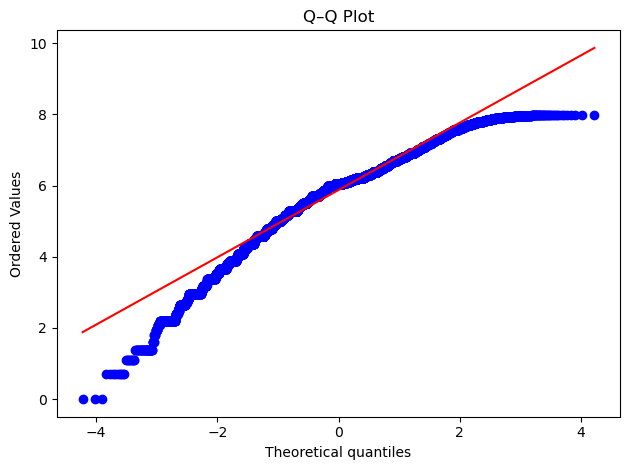

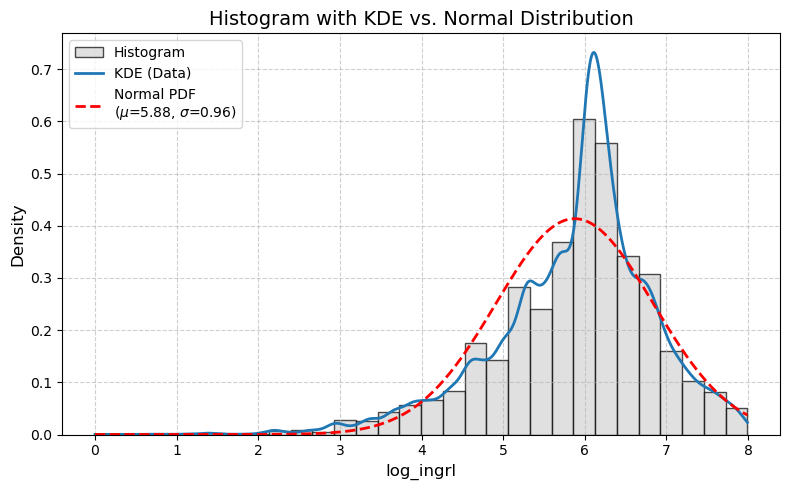

----------------------------------------
Normality tests:

Anderson–Darling statistic: 629.4444736753649
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
At 15.0% level: Reject normality
At 10.0% level: Reject normality
At 5.0% level: Reject normality
At 2.5% level: Reject normality
At 1.0% level: Reject normality

D’Agostino–Pearson p-value: 0.0
Reject normality (p < 0.1)
----------------------------------------


In [8]:
data = df['log_ingrl']
print_normal_plots(data)
normal_tests(data)

# SAE-NER

$
\hat{\mu}_{dj|s} = 
\begin{cases}
\mathbf{x}_{dj}' \hat{\boldsymbol{\beta}} + \hat{u_d} & \text{si } n_d \neq 0, \\
\mathbf{x}_{dj}' \hat{\boldsymbol{\beta}} & \text{si } n_d = 0,
\end{cases}
$


$
\hat{\mathbf{V}}_{dj|s} = 
\begin{cases}
\hat{\sigma}_u^2 (1 - \hat{\gamma}_d) + \hat{\sigma}_e^2 & \text{si } n_d \neq 0, \\
\hat{\sigma}_u^2 + \hat{\sigma}_e^2 & \text{si } n_d = 0.
\qquad
\hat{\gamma}_d = \frac{\hat{\sigma}_u^2}{\hat{\sigma}_u^2 + \hat{\sigma}_e^2/n_d}.
\end{cases}
$


$
\hat{z}_{dj}^{ebp} = \exp\left\{ \frac{1}{2} \hat{V}_{dj|s} + \hat{\mu}_{dj|s} \right\}
$


In [ ]:
def ebp_ner(model_specification, sample_dataset, population_dataset, area_name):
    sample_dataset = sample_dataset.copy()
    population_dataset = population_dataset.copy()
    y_var_name = model_specification.split("~")[0].strip()
    # -------------------------------------------------------------------#
    # Sample NER estimation
    ## NER model
    ner = smf.mixedlm(model_specification, 
                    sample_dataset, 
                    groups=sample_dataset[area_name])
    ner = ner.fit(reml=True,maxiter=10_000)
    sample_dataset['xb'] = ner.fe_params @ ner.model.exog.T

    l = []
    for d, u_d in ner.random_effects.items():
        l.append([int(d), u_d.item()])

    u_d = pd.DataFrame(l, columns=[area_name, 'u_d'])
    try:
        del sample_dataset['u_d']
    except:
        pass
    sample_dataset = sample_dataset.merge(u_d, on= area_name)

    sample_dataset['y_pred'] = sample_dataset['xb'] + sample_dataset['u_d']
    sample_dataset = sample_dataset[sample_dataset['y_pred'].isna()==False]

    # Adjust metrics
    r2 = r2_score(
        y_true=sample_dataset[y_var_name],
        y_pred= sample_dataset['y_pred'])
    rmse = np.sqrt(mean_squared_error(sample_dataset[y_var_name], sample_dataset['y_pred']))
    relative_rmse = (rmse / sample_dataset[y_var_name].mean()) * 100

    ## error term
    sample_dataset['e_dj'] = sample_dataset[y_var_name] - sample_dataset['y_pred']  

    # -------------------------------------------------------------------#
    #  population ebp computation
    sigma_u_est = ner.cov_re.iloc[0, 0]**.5
    sigma_e_est = ner.scale**.5

    rhs = model_specification.split("~", 1)[1].strip()
    X_pop = patsy.dmatrix("1 + " + rhs,
                        population_dataset,
                        return_type="dataframe")
    population_dataset["xb"] = X_pop.dot( ner.fe_params )

    l = []
    for d, u_d in ner.random_effects.items():
        l.append([int(d), u_d.item()])

    u_d = pd.DataFrame(l, columns=[area_name, 'u_d'])

    n_d = sample_dataset.groupby(area_name).size().reset_index()
    n_d = n_d.rename(columns={0:"n_d"})
    gamma_d  = n_d.copy()
    gamma_d['gamma_d'] = (sigma_u_est**2)/((sigma_u_est**2 + sigma_e_est**2/gamma_d['n_d']))

    population_dataset_sae = pd.merge(
        left=population_dataset,
        right=u_d,
        on=area_name,
        how='left'
    )

    population_dataset_sae = pd.merge(
        left=population_dataset_sae,
        right=gamma_d,
        on=area_name,
        how='left'
    )

    cond_1 = lambda x: x['u_d'].isna()==False
    cond_2 = lambda x: x['u_d'].isna()==True
    population_dataset_sae.loc[cond_1, 'mu'] = population_dataset_sae.loc[cond_1, 'xb'] +  population_dataset_sae.loc[cond_1, 'u_d']
    population_dataset_sae.loc[cond_2, 'mu'] = population_dataset_sae.loc[cond_2, 'xb'] 

    population_dataset_sae.loc[cond_1, 'V'] = (1-population_dataset_sae.loc[cond_1, 'gamma_d'])*sigma_u_est**2 + sigma_e_est**2
    population_dataset_sae.loc[cond_2, 'V'] = sigma_u_est**2 + sigma_e_est**2

    population_dataset_sae['z'] = np.exp(1/2*population_dataset_sae['V'] + population_dataset_sae['mu'])

    tx1 = population_dataset_sae.groupby(area_name)['z'].mean().reset_index()
    tx1 = tx1.rename(columns={'z':'z_ebp'})
    tx1['z_ebp'] = np.round(tx1['z_ebp'],2)

    results = {
        'r2': r2,
        'rmse': rmse,
        'relative_rmse':relative_rmse,
        'ner_summary': ner.summary(),
        'ner_model': ner,
        'ebps': tx1,
        'sigma_u_est': sigma_u_est,
        'sigma_e_est': sigma_e_est,
        'e_dj':sample_dataset['e_dj'],
        'u_d':u_d,
        'xb_pop': population_dataset_sae['xb'],
        'xb_sample': sample_dataset['xb'],
        'n_d': n_d
    }
    return results

area_name = "parroquia"
ebp_ner_res = ebp_ner(
    model_specification = "log_ingrl ~ sexo + edad + asistencia + sabe_leer + titulo + C(prov)  + C(categoria_ocupacion) + C(etnia) + C(nivel_instruccion) + C(estado_conyugal) + C(grupo_1) + C(rama_1) + C(aporte)",
    area_name = area_name,
    sample_dataset = df,
    population_dataset = df_c
)

In [ ]:
def bootstrap_iteration(sample_dataset, population_dataset, ebp_ner_res, area_name, model_specification):
    sample_population_size = sample_dataset.shape[0] + population_dataset.shape[0]
    all_areas = np.unique(population_dataset[area_name].astype(int).to_list() + sample_dataset[area_name].astype(int).to_list())

    # Bootstrap Superpopulation
    e_dj_super = np.random.normal(
        loc = 0,
        scale = ebp_ner_res['sigma_e_est'],
        size = sample_population_size
        ) # scale = std. deviation 
    u_d_super = np.random.normal(
        loc = 0,
        scale = ebp_ner_res['sigma_u_est'],
        size = len(all_areas)
        ) # scale = std. deviation 

    u_d_super = pd.DataFrame({area_name:all_areas,'u_d_super':u_d_super})

    sample_dataset['e_dj_super'] = e_dj_super[0:sample_dataset.shape[0]]
    population_dataset['e_dj_super'] = e_dj_super[sample_dataset.shape[0]:]

    sample_dataset = pd.merge(
        left = sample_dataset,
        right = u_d_super,
        on = area_name,
        how = 'left'
    )
    population_dataset = pd.merge(
        left = population_dataset,
        right = u_d_super,
        on = area_name,
        how = 'left'
    )

    population_dataset['y_dj_super'] =  ebp_ner_res['xb_pop'] + population_dataset['e_dj_super'] + population_dataset['u_d_super']
    population_dataset['z_dj_super'] = np.exp(population_dataset['y_dj_super'])

    sample_dataset['y_dj_super'] = ebp_ner_res['xb_sample'] + sample_dataset['e_dj_super'] + sample_dataset['u_d_super']
    sample_dataset['z_dj_super'] = np.exp(sample_dataset['y_dj_super'])

    z_d_super = population_dataset.groupby(area_name)['z_dj_super'].mean().reset_index()
    z_d_super = z_d_super.rename(columns={'z_dj_super':'z_d_super'})

    ebp_ner_res_super = ebp_ner(
        model_specification = model_specification,
        area_name = area_name,
        sample_dataset = sample_dataset,
        population_dataset = population_dataset
    )
    mse_b = pd.merge(z_d_super,ebp_ner_res_super['ebps'], on ='parroquia')
    converged = ebp_ner_res['ner_summary'].tables[0].iloc[4,3]
    return mse_b,converged

model_specification = "y_dj_super ~ sexo + edad + asistencia + sabe_leer + titulo + C(prov)  + C(categoria_ocupacion) + C(etnia) + C(nivel_instruccion) + C(estado_conyugal) + C(grupo_1) + C(rama_1) + C(aporte)"


# your worker function must be at top level
def do_bootstrap(i, df, df_c, ebp_ner_res, area_name, model_spec):
    try:
        bi = bootstrap_iteration(
            sample_dataset=df,
            population_dataset=df_c,
            ebp_ner_res=ebp_ner_res,
            area_name=area_name,
            model_specification=model_spec
        )
        return bi[0] if bi[1]=='Yes' else None
    except:
        return None

n_jobs = multiprocessing.cpu_count()  # or set to e.g. 4
n_jobs = 10
outputs = Parallel(
    n_jobs=n_jobs,
    backend="loky",    # loky is the default, it uses processes + dill for serialization
    verbose=10         # optional: see progress
)(
    delayed(do_bootstrap)(
        i, df, df_c, ebp_ner_res, area_name, model_specification
    )
    for i in range(200)
)

results = [o for o in outputs if o is not None]



In [ ]:
b = []
for i in results:
    i = i.sort_values('parroquia')
    i['diff2'] = (i['z_d_super'] - i['z_ebp'])**2
    b.append(i['diff2'])

ebps = ebp_ner_res['ebps']
ebps['ee'] = np.sqrt(pd.DataFrame(b).T.mean(axis=1))

ebps['cv'] = ebps['ee']/ebps['z_ebp']

In [ ]:
ebps.to_csv("sae_ner_results_full_country.csv", index=False)

According to the UK Office for National Statistics guidelines (as cited in Chambers, Salvati, & Tzavidis, 2016), estimates with a coefficient of variation (CV) below 20% are deemed publishable. According to the Ecuadorial National Institute of Statistics EBPs below 30% are deemed publishable (Morales & Villacreses, 2022).

References
* Chambers, R., Salvati, N., & Tzavidis, N. (2016). Semiparametric small area estimation for binary outcomes with application to unemployment estimation for local authorities in the UK. Journal of the Royal Statistical Society. Series A (Statistics in Society), 179(2), 453–479. http://www.jstor.org/stable/43965552

* Morales, D. and Villacreses, D. (2022). Una Aproximación a la Estimación en Áreas Pequeñas de la
Desnutrición Crónica Infantil en Ecuador (Vol. 13, Ser. Cuadernos de Trabajo). Instituto Nacional de Estadística y Censos. https://www.ecuadorencifras.gob.ec/documentos/web-inec/Bibliotecas/Libros/cuadernos_trabajo/DocumentoMetodol%C3%B3gico_SaeNerDci.pdf


According to Ziyang Lyu & A.H. Welsh (2021): Asymptotics for EBLUPs:
Nested Error Regression Models, Journal of the American Statistical Association, DOI:
10.1080/01621459.2021.1895178


Under the framework of Lyu & Welsh (2021), the unit‐level EBLUP remains consistent, asymptotically normal and delivers accurate MSE approximations under only mild moment conditions—precisely those satisfied by any skew‐normal distribution with finite fourth moments. Their extensive simulation experiments, which include heavily bimodal mixtures and skew‐normal cases, showed virtually no loss in bias or MSE even under pronounced non-Gaussianity. Because my area effects and residuals clearly follow a skew-normal law yet meet the paper’s finite‐moment requirements, the standard EBLUP methodology of Molina & Rao (2010) can be confidently applied to my data.